#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Открытие-файла-и-предобработка-данных" data-toc-modified-id="Открытие-файла-и-предобработка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Открытие файла и предобработка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Регрессия-Lasso" data-toc-modified-id="Регрессия-Lasso-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Регрессия Lasso</a></span></li><li><span><a href="#Регрессия-Ridge" data-toc-modified-id="Регрессия-Ridge-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Регрессия Ridge</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Дерево решений</a></span></li></ul></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Сравнение моделей</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Проверка-модели-на-адекватность" data-toc-modified-id="Проверка-модели-на-адекватность-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Проверка модели на адекватность</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Открытие файла и предобработка данных

In [1]:
# Импорт библиотек
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.stattools import adfuller
from sklearn.dummy import DummyRegressor

In [2]:
# Избавимся от предупреждений
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Откроем файл с данными
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
# Посмотрим на структуру данных
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
# Выведем общую инорфмацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Для анализа и построения модели нам доступен столбец с данными о количестве заказов такси в интервале 10 минут. Пропуски в данных отсутствуют. Посмотрим, в каком диапазоне лежат данные

In [6]:
print(f'Данные представлены за период с {data.index.min()} по {data.index.max()}')

Данные представлены за период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00


Нам доступны данные за период с 1 марта 2018 года по 31 августа 2018 года. Проверим, чтобы данные были представлены по порядку, так как во временных рядах нельзя нарушать последовательность

In [7]:
if data.index.is_monotonic:
    print('Данные расположены в хронологическом порядке')
else:
    print('Необходимо упорядочить данные')

Данные расположены в хронологическом порядке


Выполним ресепмлирование данных по одному часу

In [8]:
data = data.resample('1H').sum()
# data.head()

Мы открыли файл и провели первичную предобработку данных:
- вывели общую информацию о датасете
- определили период, за которые представлены данные
- проверили данные на расположение в хронологическом порядке, что важно для временных рядов
- выполнили ресемплирование данных по одному часу

## Анализ

Для анализа и построения моделей напишем функцию для создания признаков

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    
    # Календарные признаки
    data_adjusted = data.copy()
    data_adjusted['day'] = data_adjusted.index.day
    data_adjusted['dayofweek'] = data_adjusted.index.dayofweek
    
    # Отстающие значения
    for lag in range(1, max_lag + 1):
        data_adjusted['lag_{}'.format(lag)] = data_adjusted['num_orders'].shift(lag)

    # Скользящее среднее
    data_adjusted['rolling_mean'] = (
        data_adjusted['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
    
    return data_adjusted

В качестве параметров возьмем 160 как максимальное количество лагов в зависимой переменной и 10 дней в качестве размера окна, за которое будет выполняться усреднение

In [10]:
data_adjusted = make_features(data, 160, 10)

Построим график скользящего среднего

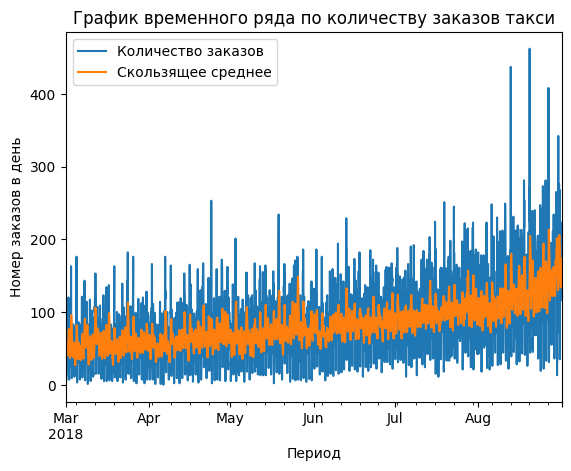

In [11]:
data_adjusted[['num_orders', 'rolling_mean']].plot()
plt.legend(['Количество заказов', 'Скользящее среднее'])
plt.ylabel('Номер заказов в день')
plt.xlabel('Период')
plt.title('График временного ряда по количеству заказов такси');

Исследуем ряд на стационарность с помощью теста Дики - Фуллера 

In [12]:
results = adfuller(data_adjusted['num_orders'], maxlag=160)
#results

# гипотезы
print('H_0: ряд не стационарен\n'
'H_1: ряд стационарен\n')

# Выведем результат Т статистики, p-value и критические значения статистики
print(f'T-statistics: {results[0]}\n'
     f'p-value: {results[1]}\n'
     f'T-critical: {results[4]}\n')

# Проведем тест на 5% и 1% уровнях значимости и выведем результаты
for alpha in ['5%', '1%']:
    if results[0] > results[4][alpha]:
        print(f'Нулевая гипотеза не отвергнута на {alpha} уровне значимости, ряд не стационарен')
    else:
        print(f'Нулевая гипотеза отвергнута на {alpha} уровне значимости, ряд стационарен')

H_0: ряд не стационарен
H_1: ряд стационарен

T-statistics: 2.158906259830947
p-value: 0.9988469547429499
T-critical: {'1%': -3.431887778940827, '5%': -2.862219505822837, '10%': -2.5671317062666303}

Нулевая гипотеза не отвергнута на 5% уровне значимости, ряд не стационарен
Нулевая гипотеза не отвергнута на 1% уровне значимости, ряд не стационарен


Основываясь на результатах теста Дики-Фуллера, ряд не стационарен, что также можно заметить на графике скользящего среднего  
  
Выделим тренды и сезонность для лучшего понимания временного ряда

In [13]:
def decomposed_analysis(data):
    decomposed = seasonal_decompose(data['num_orders'])

    plt.figure(figsize=(6, 8))
    plt.subplot(311)

    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.ylabel('Количество заказов')
    plt.xlabel('Период')

    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.ylabel('Количество заказов')
    plt.xlabel('Период')

    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.ylabel('Количество заказов')
    plt.xlabel('Период')

    plt.tight_layout()

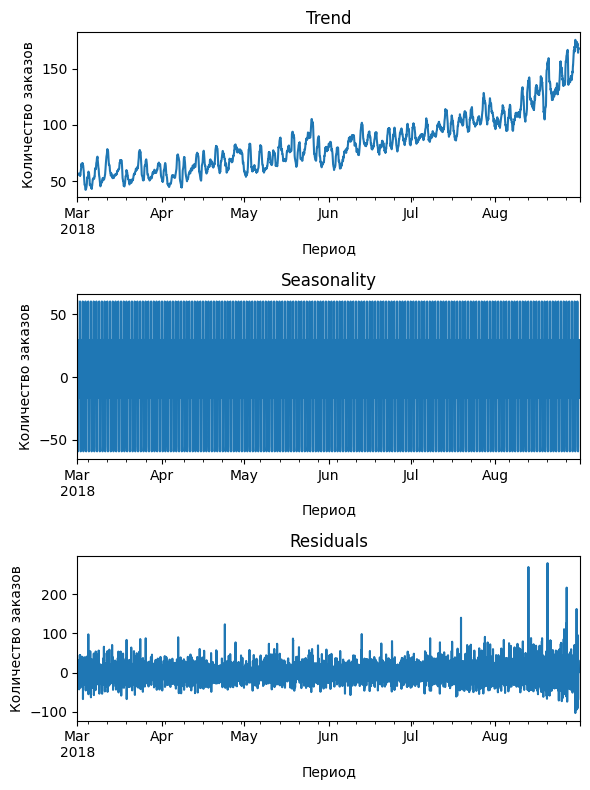

In [14]:
decomposed_analysis(data_adjusted)

Судя по графику тренда, наблюдается тенденция к увеличению количества заказов в день ближе к осени, что также наблюдалось в графике со скользящим средним. Ряд нестационарный, так как с течением времени изменяется среднее значение целевой переменной. Нестационарность ряда также подтверждается результатами теста Дики-Фуллера  
  
  Остатки ведут себя стабильно до августа, а после разброс в ошибке увеличивается. Так как разброс в ошибке присутствует не на всем периоде, мы можем сделать допущение о стационарности ряда исходя из графиика ошибок

Исследуем сезонность более подробно. Для этого рассмотрим более короткий промежуток времени

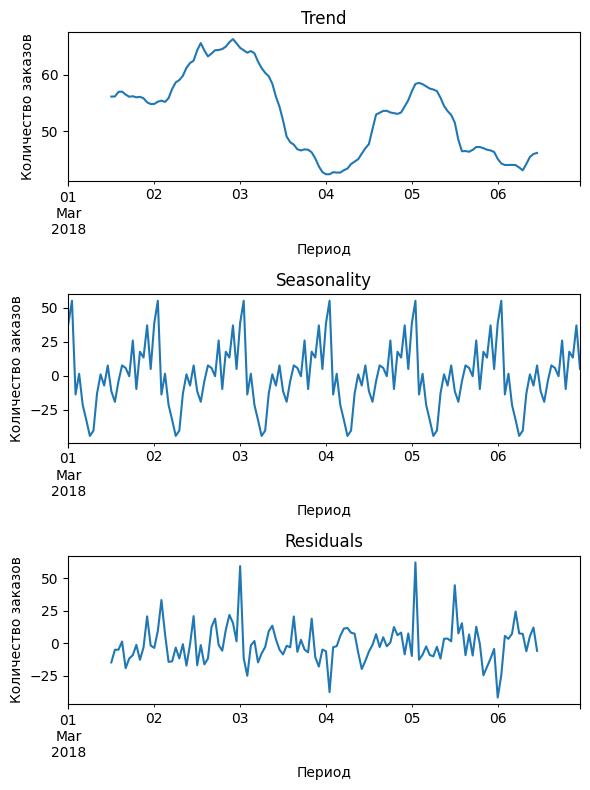

In [15]:
decomposed_analysis(data_adjusted['2018-03-01':'2018-03-06'])

Наблюдается суточная сезонность, выведем график двух дней

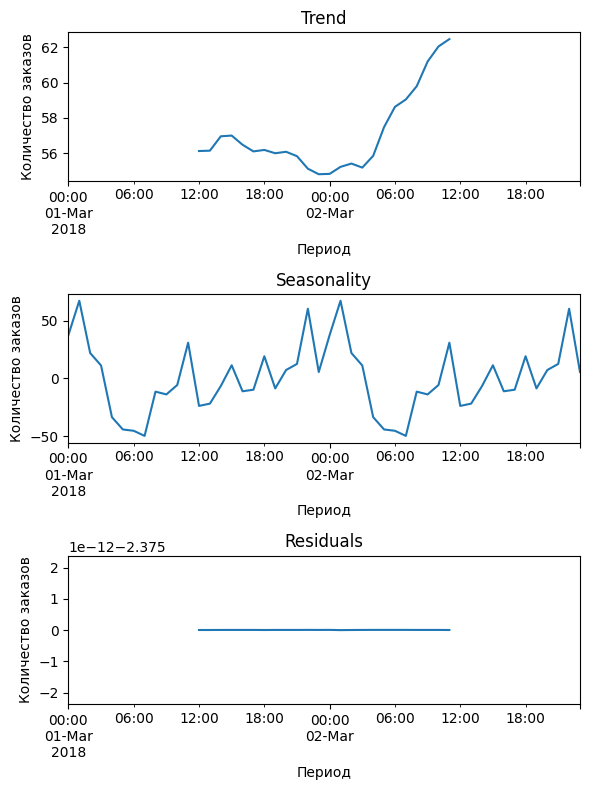

In [16]:
decomposed_analysis(data_adjusted['2018-03-01':'2018-03-02'])

Заметно, что количество заказов падает ночью, а ближе к утру стремительно растет
  
  Так как нам представлены данные о заказах такси в аэропортах, сезонность обусловлена временем прилета самолетов

В данном разделе мы проанализировали временной ряд. Можно отметить следующие моменты:
- Мы создали признаки для анализа и построения моделей
- Провели тест Дики-Фуллера на стационарность. Выяснили, что ряд не стационарен
- Разделили ряд на тренд, сезонную компоненту и ошибку
- Проанализировали сезонную компоненту, определив часовой тип сезонности
- По графику остатков мы сделали допущение о стационарности ряда

## Обучение

In [17]:
# Удалим строчки с пропусками
data_adjusted = data_adjusted.dropna()

In [18]:
# Сохраним признаки и таргет в отдельные переменные
features = data_adjusted.drop('num_orders', axis=1)
target = data_adjusted['num_orders']

# Разделим выборку на обучающую и тесттовую
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.1, shuffle=False)

In [19]:
# Для провередния кросс-валидации сохраним разделение временного ряда в отдельную переменную
tscv = TimeSeriesSplit(n_splits=5) 

### Линейная регрессия

In [20]:
regression = LinearRegression()

rmse_regression = cross_val_score(regression, features_train, target_train,
                                    scoring='neg_root_mean_squared_error', cv=tscv).mean() * (-1)

print(f'RMSE для модели линейной регрессии: {rmse_regression}')

RMSE для модели линейной регрессии: 24.067871150983983


###  Регрессия Lasso

In [21]:
rmse_lasso = 10 ** 10
alpha_lasso = 0
lasso = None

for alpha in [0.01, 0.1, 0.5, 1, 10, 100, 1000]:
    model = Lasso(alpha=alpha, random_state=12345)
    model.fit(features_train, target_train)
    
    rmse = cross_val_score(model, features_train, target_train, 
                           scoring='neg_root_mean_squared_error', cv=tscv).mean() * (-1)
    
    if rmse < rmse_lasso:
        lasso = model
        alpha_lasso = alpha
        rmse_lasso = rmse

print(f'Значение параметра alpha на лучшей модели: {alpha_lasso}\n'
      f'RMSE для модели регрессии Lasso: {rmse_lasso}')

Значение параметра alpha на лучшей модели: 10
RMSE для модели регрессии Lasso: 23.3249082416261


### Регрессия Ridge

In [22]:
rmse_ridge = 10 ** 10
alpha_ridge = 0
ridge = None

for alpha in [0.01, 0.1, 0.5, 1, 10, 100, 1000]:
    model = Ridge(alpha=alpha, random_state=12345)
    model.fit(features_train, target_train)
    
    rmse = cross_val_score(model, features, target, 
                           scoring='neg_root_mean_squared_error', cv=tscv).mean() * (-1)
    
if rmse < rmse_ridge:
    ridge = model
    alpha_ridge = alpha
    rmse_ridge = rmse
        
print(f'Значение параметра alpha на лучшей модели: {alpha_ridge}\n'
        f'RMSE для модели регрессии Lasso: {rmse_ridge}')

Значение параметра alpha на лучшей модели: 1000
RMSE для модели регрессии Lasso: 26.23931047910015


### Дерево решений

In [23]:
rmse_tree = 10 ** 10
depth_tree = 0
min_splits = 0
tree = None

for depth in range(1, 6):
    for split in range(2, 11):
        model = DecisionTreeRegressor(max_depth=depth, min_samples_split=split, random_state=12345)
    
        rmse = cross_val_score(model, features_train, target_train, 
                               scoring='neg_root_mean_squared_error', cv=tscv).mean() * (-1)
    
        if rmse < rmse_tree:
            tree = model
            depth_tree = depth
            min_splits = split
            rmse_tree = rmse

print(f'Максимальная глубина дерева на лучшей модели: {depth_tree}\n'
      f'Минимальное количество выборок для разделения узла: {min_splits}\n'
        f'RMSE для модели дерева решений: {rmse_tree}')

Максимальная глубина дерева на лучшей модели: 4
Минимальное количество выборок для разделения узла: 5
RMSE для модели дерева решений: 28.170238427338166


## Сравнение моделей

In [24]:
rmse_table = pd.DataFrame(
    {
        'Модель': ['Линейная регрессия', 'Регрессия Lasso', 'Регрессия Ridge', 'Дерево решений'],
        'RMSE на обучающей выборке': [rmse_regression, rmse_lasso, rmse_ridge, rmse_tree]
    }
)
rmse_table = rmse_table.set_index('Модель')
rmse_table

,RMSE на обучающей выборке
Модель,
Линейная регрессия,24.067871
Регрессия Lasso,23.324908
Регрессия Ridge,26.239310
Дерево решений,28.170238


Модель регрессии Lasso дала наилучший результат метрики MSE на обучающей выборке. Протестируем данную модель на тестовой выборке

## Тестирование

In [25]:
lasso_predictions_test = lasso.predict(features_test)
rmse_lasso_test = mean_squared_error(target_test, lasso_predictions_test, squared=False)
print(f'Значение RMSE на тестовой выборке модели регрессии Lasso: {rmse_lasso_test}')

Значение RMSE на тестовой выборке модели регрессии Lasso: 38.93571252376194


Значение RMSE на тестовой выборке ниже порогового значения 48. Однако, стоит отметить, что модель склонна к переобучению, так как значение корня из среднеквадратичной ошибки на обучающей выборке гораздо ниже, чем на тестовой выборке. Возможно, тенденция к переобучению модели возникает из-за нестационарности ряда.  
  
Так как было достигнуто желаемое значение RMSE, цель проекта была достигнута. Для лучшего понимания, где модель хорошо работает, а где ошибается, построим график сравнения целевого признака и предсказаний модели на тестовой выборке

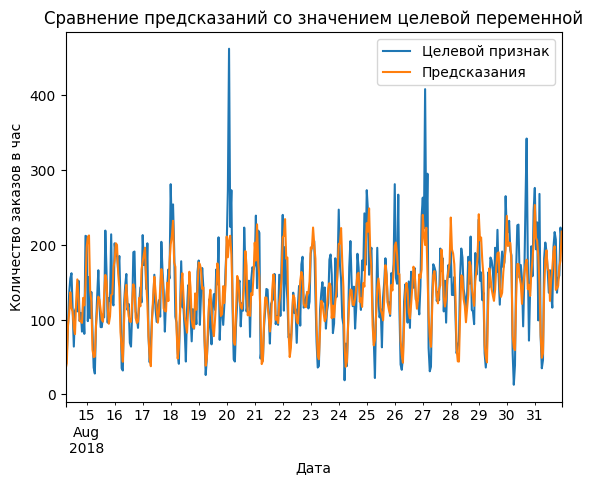

In [26]:
target_predictions_data = pd.DataFrame({'Target': target_test, 
                                        'Predictions': lasso_predictions_test})
#target_predictions_data
target_predictions_data.plot()
plt.legend(['Целевой признак', 'Предсказания'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов в час')
plt.title('Сравнение предсказаний со значением целевой переменной')
plt.show()

Модель плохо предсказывает выбросы, но сохраняет основную динамику тренда почасового количества заказов в сутки, что в целом подтверждает надежность предсказаний

## Проверка модели на адекватность

Для проверки модели на адекватность, сравним ее с примитивной моделью DummyRegressor, делающей константные предсказания. В качестве стратегии возьмем медиану

In [27]:
dummy_model = DummyRegressor(strategy='median')
dummy_model.fit(features_train, target_train)
dummy_predictions_test = dummy_model.predict(features_test)
rmse_dummy_test = mean_squared_error(target_test, dummy_predictions_test, squared=False)

# Выведем точность модели DummyClassifier на экран
print(f'RMSE модели DummyRegressor - {rmse_dummy_test}')

# Сравним точность модели DummyClassifier с точностью модели регрессии Lasso
if rmse_dummy_test < rmse_lasso_test:
    print('Модель регрессии Lasso дает неточные результаты по сравнению с самой простой моделью'
         'DummyRegressor')
elif rmse_dummy_test > rmse_lasso_test:
    print('Модель регрессии Lasso дает адекватные результаты')
else:
    print('Модели регрессии Lasso и DummyRegressor дают одинаковую точность. Лучше выбрать '
          'другую модель')

RMSE модели DummyRegressor - 86.94990733161552
Модель регрессии Lasso дает адекватные результаты


Таким образом, модель регрессии Lasso прошла проверку на желаемый результат RMSE от заказчика и проверку на адекватность. Следовательно, модель может быть представлена заказчику

## Вывод

Подводя итоги, целью данного проекта было построить модель, предсказывающую количество заказов такси на следующий час. Предсказания модели должны использоваться для того, чтобы привлекать больше водителей в часы пиковой загрузки. Заданный бенчмарк RMSE модели - ниже 48.  
  
  Для начала мы открыли файл с данными и изучили его свойства. Нам представлены данные за период с 1 марта по 31 августа 2018 года в 10 - минутном интервале. Убедившись, что данные расположены в хронологическом порядке, мы провели их ресемплирование по одному часу.  
   
Далее мы проанализировали данные в изначальной выборке. Были выделены следующие моменты:
- Наличие тенденции на увеличение количества заказов к осени
- Нестационарность ряда  
  
Также, мы добавили дополнительные признаки в датасет для построения модели: 
- Календарные признаки: год, месяц, день, день недели
- Отстающие значение: 160 лагов
- Скользящее среднее: размер окна, за котрое выполняется усреднение, -  10 дней  
     
Далее мы обучили следующие модели на тренировочной выборке:
- Линейная регрессия
- Регрессия Lasso
- Регрессия Ridge
- Дерево решений  
  
Наилучший результат корня из среднеквадратичной ошибки на обучающей выборке показала модель регрессии Lasso со значением RMSE около 23.32. При проверке модели на тестовой выборке было преодалено пороговое значение RMSE: получилось примерно 38.93, что ниже бенчмарка - 48. Однако, стоит отметить, что модель склонна к переобучению из-за довольно большой разницы между значениями RMSE на обучающей и тестовой выборках, что возможно является следствием нестационарностип ряда. При построении графика сравнения целевых значений и предсказаний мы выяснили, что модель регрессии Lasso сохраняет основную динамику суточного тренда по количеству заказов в сутки, делая ошибки в предсказании выбросов.
  
Также, была проведена проверка на адекватность предложенной модели с помощью DummyRegressor, делающим предсказания по медиане. Так как RMSE примитивной модели получился гораздо выше RMSE регрессии Lasso, модель прошла проверку на адекватость.
  
Так как было пройдено пороговое значение корня из среднеквадратичной ошибки модели на тесовой выборке и модель продемонстрировала адекватные предсказания, цель проекта была выполнена. Следовательно, модель может быть преставлена заказчику.